## Spatially resolved Mass-Metallicity relation for EDGE, at CALIFA resolution.

In [1]:
import os
import numpy as np
from astropy.table import Table, join, Column
import matplotlib.pyplot as plt
from astropy import units as u
import h5py 
import edge_pydb.util as edgeutil
from edge_pydb import EdgeTable
from edge_pydb.xy2hist import xy2hist
from edge_pydb.conversion import stmass_pc2, msd_co, ZOH_M13, bpt_type
np.seterr(invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## Load data from the HDF5 files

In [2]:
# Get a listing of all HDF5 files
edgeutil.listfiles("hdf5")

['NGC4047.pipe3d.hdf5',
 'edge.pipe3d.hdf5',
 'edge.cocube_smo7.hdf5',
 'NGC4047.cocube_smo7.hdf5',
 'NGC4047.comom_smo7.hdf5',
 'edge.comom_smo7.hdf5']

In [3]:
fluxcols = ['Name','ix','iy','flux_Halpha_sm','flux_Hbeta_sm','e_flux_Halpha_sm',
          'flux_[NII]6583_sm','flux_[OIII]5007_sm','EW_Halpha_sm','ZOH_sm','BPT_sm']
sspcols = ['Name','ix','iy','mass_ssp_sm','sigstar_sm']

try:
    fluxtab = EdgeTable('edge.pipe3d.hdf5', path='flux_elines_sm',
                        cols=fluxcols)
    ssptab = EdgeTable('edge.pipe3d.hdf5', path='SSP_sm', cols=sspcols)
    cotab = EdgeTable('edge.comom_smo7.hdf5', path='smo')
    print('Working on full EDGE database')
except:
    fluxtab = EdgeTable('NGC4047.pipe3d.hdf5', path='flux_elines_sm',
                        cols=fluxcols)
    ssptab = EdgeTable('NGC4047.pipe3d.hdf5', path='SSP_sm', cols=sspcols)
    cotab = EdgeTable('NGC4047.comom_smo7.hdf5', path='smo')
    print('Working on NGC 4047 data')

Working on full EDGE database


## Build the table

In [4]:
fluxtab.join(ssptab, keys=['Name', 'ix', 'iy'])
fluxtab.join(cotab, keys=['Name', 'ix', 'iy'])
print(fluxtab.colnames)

['Name', 'ix', 'iy', 'flux_Halpha_sm', 'flux_Hbeta_sm', 'e_flux_Halpha_sm', 'flux_[NII]6583_sm', 'flux_[OIII]5007_sm', 'EW_Halpha_sm', 'ZOH_sm', 'BPT_sm', 'mass_ssp_sm', 'sigstar_sm', 'ra_off', 'dec_off', 'rad_arc', 'azi_ang', 'emom0max', 'mom0', 'emom0', 'sigmol', 'e_sigmol']


## Plot the mass-metallicity relation

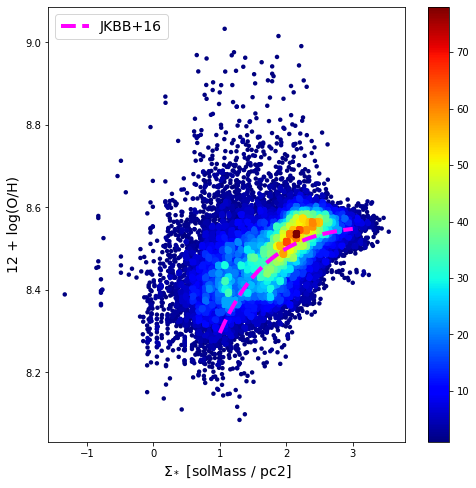

In [5]:
sig_star = fluxtab['sigstar_sm']
ZOH = fluxtab['ZOH_sm']
not_nan = ((~np.isnan(sig_star)) & (~np.isnan(ZOH)) & (sig_star>0) & (ZOH>0))
x_det, y_det, z_det, *hist = xy2hist(np.log10(sig_star[not_nan]), 
                                     ZOH[not_nan], log=False)

fig, ax = plt.subplots(figsize=(8,8))
cm = plt.cm.get_cmap('jet')
sc = ax.scatter(x_det, y_det, c=z_det, s=20, edgecolor='', cmap=cm)
# From MaNGA paper, doi:10.1093/mnras/stw1984
xmod = np.linspace(1,3,num=50)
ymod = 8.55 + 0.014*(xmod-3.14)*np.exp(-(xmod-3.14))
plt.plot(xmod,ymod,color='magenta',ls='--',lw=4,label='JKBB+16')
plt.legend(loc='upper left',fontsize=14)
plt.xlabel('$\Sigma_*$ ['+str(sig_star.unit)+']',fontsize=14)
plt.ylabel('12 + log(O/H)',fontsize=14)
plt.colorbar(sc)

## Metallicity vs. stellar-to-gas mass ratio

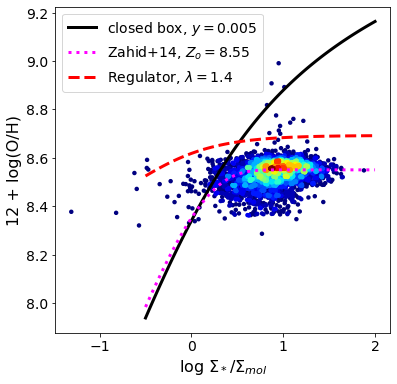

In [6]:
ratio = Column(sig_star/fluxtab['sigmol'], name='ratio')
codet = (not_nan) & (fluxtab['sigmol']>3*fluxtab['e_sigmol'])
x_det, y_det, z_det, *hist = xy2hist(np.log10(ratio[codet]), 
                                 ZOH[codet], log=False)

fig, ax = plt.subplots(figsize=(6,6))
cm = plt.cm.get_cmap('jet')
sc = ax.scatter(x_det, y_det, c=z_det, s=20, edgecolor='', cmap=cm)

# Closed box model with fixed yield
yld = 0.005
xmod = np.linspace(-0.5,2,100)  # log(\Sigma_*/\Sigma_gas)
ymod = 10.80 + np.log10(yld*np.log(1+10**xmod))
plt.plot(xmod, ymod, linestyle='-', lw=3, color='k', label='closed box, $y=$'+str(yld))

# Universal relation of Zahid+14 (2014ApJ...791..130Z), Eqn (5) + (20)
Zo = 8.55
ymod2 = Zo + np.log10(1-np.exp(-10**xmod))
plt.plot(xmod, ymod2, linestyle=':', lw=3, color='magenta', label='Zahid+14, $Z_o=$'+str(Zo))

# Gas regulator model with constant mass loading factor lambda = 1.4
R   = 0.4
eps = -0.25
lam = 1.4
yld = 0.014
Z0  = 3e-3
Z = Z0 + yld/(1+10**(-xmod)+(lam+eps)/(1-R))  # Eq. 11 of 2018ApJ...852...74B
ymod3 = 10.80 + np.log10(Z)
plt.plot(xmod, ymod3, linestyle='--', lw=3, color='r', label='Regulator, $\lambda=$'+str(lam))

plt.legend(loc='upper left',fontsize=14)
plt.xlabel('log $\Sigma_*/\Sigma_{mol}$',fontsize=16)
plt.ylabel('12 + log(O/H)',fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
#plt.colorbar(sc)
#plt.savefig('mumet.png')

## Calculate the metallicity using N2 estimator

Number of points: 351125


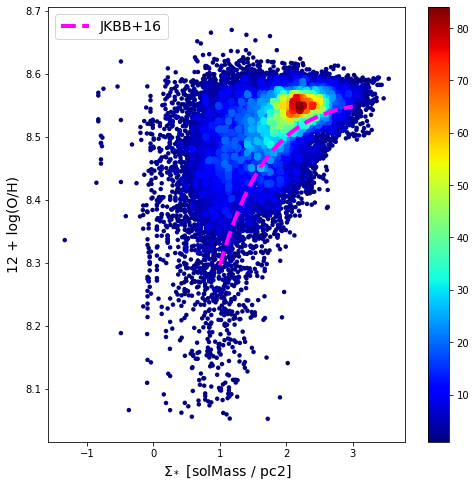

In [7]:
ZOH_N2 = ZOH_M13(fluxtab, ext='_sm', method='n2', err=False)
print('Number of points:',len(ZOH))
not_nan = (~np.isnan(sig_star)
          ) & (~np.isnan(ZOH_N2)) & (sig_star>0) & (ZOH_N2>0)
x_det, y_det, z_det, *hist = xy2hist(np.log10(sig_star[not_nan]), 
                                     ZOH_N2[not_nan], log=False)

fig, ax = plt.subplots(figsize=(8,8))
cm = plt.cm.get_cmap('jet')
sc = ax.scatter(x_det, y_det, c=z_det, s=20, edgecolor='', cmap=cm)
# From MaNGA paper, doi:10.1093/mnras/stw1984
xmod = np.linspace(1,3,num=50)
ymod = 8.55 + 0.014*(xmod-3.14)*np.exp(-(xmod-3.14))
plt.plot(xmod,ymod,color='magenta',ls='--',lw=4,label='JKBB+16')
plt.legend(loc='upper left',fontsize=14)
plt.xlabel('$\Sigma_*$ ['+str(sig_star.unit)+']',fontsize=14)
plt.ylabel('12 + log(O/H)',fontsize=14)
plt.colorbar(sc)

## Plot the BPT diagram.

In [8]:
# BPT
N2F = fluxtab['flux_[NII]6583_sm']
O3F = fluxtab['flux_[OIII]5007_sm']
HaF = fluxtab['flux_Halpha_sm']
HbF = fluxtab['flux_Hbeta_sm']
BPT = fluxtab['BPT_sm']

In [9]:
x1 = np.linspace(-3, 0.3, 100)
x2 = np.linspace(-3, -0.1, 100)
x3 = np.linspace(-0.4346, 2,100)
kewley01 = lambda nii: 1.19 + 0.61/(nii - 0.47) 
kauffm03 = lambda nii: 1.30 + 0.61/(nii - 0.05) 
cidfer10 = lambda nii: 0.48 + 1.01*nii  
xval = np.log10(N2F/HaF)
yval = np.log10(O3F/HbF)

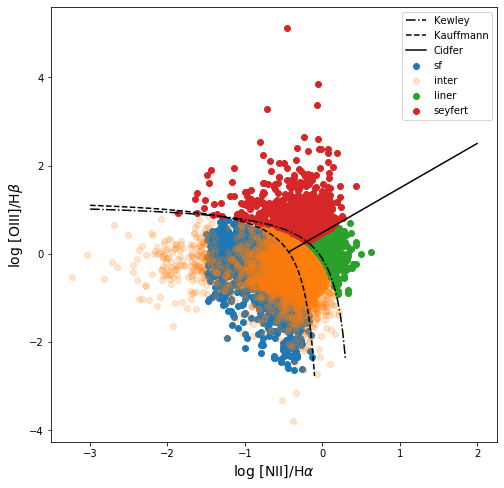

In [10]:
plt.figure(figsize=(8,8))
plt.scatter(xval[BPT==-1], yval[BPT==-1], label="sf")
plt.scatter(xval[BPT==0], yval[BPT==0], label="inter", alpha=0.2)
plt.scatter(xval[BPT==1], yval[BPT==1], label="liner")
plt.scatter(xval[BPT==2], yval[BPT==2], label="seyfert")
plt.plot(x1, kewley01(x1), 'k-.', label="Kewley")
plt.plot(x2, kauffm03(x2), 'k--', label="Kauffmann")
plt.plot(x3, cidfer10(x3), 'k-', label="Cidfer")
plt.xlabel(r'log [NII]/H$\alpha$',fontsize=14)
plt.ylabel(r'log [OIII]/H$\beta$',fontsize=14)
plt.legend()
plt.show()